# Building MapVisualiser:

Building MapVisaliser from zero based on example of Pakistan flood from 2022
1. Downloading Dask datacube (data of Pakistan with all variables) and preparing MapVisualiser
2. Refinement and variable selection
3. Building basic polygons - Polygol I
4. Creation of new variables - Product variables
5. New Variables - Binned Likelihood x Flood Extent - Polygonised
6. Creation png/img files as output 


In [1]:
frame_width=1000
frame_height=600

top_px = 380
right_px = 830

import hvplot.xarray  # ensures hvplot is registered
import holoviews as hv
hv.extension('bokeh')  # backend for HTML output

def save_base_band_html(dcloader, var_name='tuw_likelihood', html_path='base_tuw_likelihood.html',
                        cmap='Blues', frame_width=frame_width, frame_height=frame_height, title="Basic Flood Likelihood"):
    """
    Save a standalone HTML visualization of a raw band from the datacube.

    Args:
        dcloader: An initialized DcLoader with `dc` loaded.
        var_name: Variable to display (e.g., 'tuw_likelihood').
        html_path: Target HTML file path.
        cmap: Colormap (string or list).
        frame_width: Plot width in pixels.
        frame_height: Plot height in pixels.
    """
    if dcloader.dc is None:
        raise RuntimeError("DcLoader.dc is not loaded. Call load_GFM_data or load_from_netcdf first.")
    if var_name not in dcloader.dc.data_vars:
        raise ValueError(f"Variable '{var_name}' not found. Available: {list(dcloader.dc.data_vars)}")

    da = dcloader.dc[var_name]
    # If time is present, take the first slice for a quick preview
    if 'time' in da.dims and da.sizes.get('time', 0) > 0:
        da = da.isel(time=0)

    # Plain raster — no basemap — axes and grid off
    plot = da.hvplot.image(
        x='x', y='y',
        cmap=cmap,
        frame_width=frame_width,
        frame_height=frame_height,
        colorbar=True,
        xlabel='', ylabel='', title=title
    ).opts(axiswise=True, padding=0, show_grid=False)

    hv.save(plot, html_path, fmt='html')
    print(f"Saved '{var_name}' to {html_path}")
    return plot

from pathlib import Path
from bs4 import BeautifulSoup
import holoviews as hv
from typing import Union

def inject_pin_overlay(fig, html_path: Union[str, Path], top_px: int, right_px: int, title: str) -> None:
    """
    Save an HoloViews figure to HTML and inject a floating pin overlay.

    Args:
        fig: HoloViews object to save into the HTML file.
        html_path: Output HTML path (created or overwritten).
        top_px: CSS pixel offset from the top edge for the overlay.
        right_px: CSS pixel offset from the right edge for the overlay.

    Behavior:
        - Writes `fig` to `html_path`.
        - Parses the HTML and appends a small circular pin overlay to `<body>`.
        - Sets `<body>` to `position:relative` (preserves existing styles).
        - Prints where the pin was injected.
    """
    # Normalize path and save the figure
    html_path = Path(html_path)
    hv.save(fig, html_path, toolbar=None, title=title)

    # Read and parse the saved HTML
    soup = BeautifulSoup(html_path.read_text(encoding="utf-8"), "html.parser")

    # Locate body; fail early if missing
    body = soup.find("body")
    if body is None:
        raise ValueError("Cannot inject overlay: no <body> element found in HTML.")

    # Create the overlay container
    pin_container = soup.new_tag(
        "div",
        style=(
            f"position:absolute;top:{top_px}px;right:{right_px}px;"
            "background:rgba(0,0,0,0.75);color:#fff;"
            "padding:8px 12px;border-radius:6px;"
            "font:600 14px/1 'Source Sans Pro', sans-serif;"
            "z-index:9999;"
            "display:inline-flex;gap:8px;align-items:center;"
        ),
    )

    # Pin icon element
    pin_icon = soup.new_tag(
        "span",
        style=(
            "display:inline-block;width:12px;height:12px;"
            "background:#ffda00;border-radius:50%;border:2px solid #fff;"
        ),
    )
    pin_container.append(pin_icon)

    # Ensure body is relatively positioned without clobbering existing styles
    existing_style = (body.get("style") or "").strip()
    if "position:" not in existing_style:
        body["style"] = ("position:relative;" + (" " + existing_style if existing_style else "")).strip()

    # Append overlay and write back to disk
    body.append(pin_container)
    html_path.write_text(str(soup), encoding="utf-8")

    print(f"Pin injected into {html_path} @ top={top_px}px, right={right_px}px")

In [ ]:
import pystac_client
from dask.distributed import Client
import sys
from pathlib import Path
from matplotlib.colors import ListedColormap
sys.path.append(str(Path.cwd() / "dynamic-flood-visualization" / "src"))

project_root = Path.cwd().parent.parent  # goes from visualizations/jonas -> visualizations -> project root
src_path = project_root / "src"
assert src_path.exists(), f"src path not found: {src_path}"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from dcloader import DcLoader
#from dynamic-flood-visualization.src.dcloader import DcLoader
import matplotlib.pyplot as plt
import xarray as xr
from mapvisualiser import MapVisualiser
import rioxarray
import hvplot.xarray
from color_schemes import COLOR_PALETTES

cache_file = '../../data/germany_flood_cache.nc'
eodc_catalog = pystac_client.Client.open("https://stac.eodc.eu/api/v1/")
time_range_germany = '2022-09-23T01:25:51Z/2022-09-23T01:25:52Z'
time_range = "2023-10-11/2023-10-25"
time_range_germany = time_range
minlon, maxlon = 12.3, 13.1
minlat, maxlat = 54.3, 54.6
bounding_box = [minlon, minlat, maxlon, maxlat]
bounding_box_germany = bounding_box

client = Client(processes=False, threads_per_worker=2, n_workers=3, memory_limit="12GB")
print(f"Dask dashboard link: {client.dashboard_link}")
dc_loader = DcLoader(eodc_catalog)
dc_loader.load_GFM_data(time_range_germany, bounding_box_germany)

fig = save_base_band_html(dc_loader, var_name='tuw_likelihood', html_path='base_tuw_likelihood.html', cmap=COLOR_PALETTES['blue_to_red_extended'].reverse())
inject_pin_overlay(fig, "outputs/baseline_no_map.html",top_px=top_px - 10 , right_px=right_px + 25, title="Basic Flood Likelihood")
# dc must be saved and loaded again as we want to store it directly at the MaVisualiser
# as we don't want to 
flood_variables = ['dlr_likelihood', 'tuw_likelihood', 'list_likelihood', 'dlr_flood_extent', 'tuw_flood_extent', 'list_flood_extent', 'ensemble_likelihood', 'ensemble_flood_extent', 'ensemble_water_extent']
mask_variables = ['reference_water_mask', 'exclusion_mask', 'advisory_flags']
#dc_loader.compute_swath_mosaic(flood_variables=flood_variables, mask_variables=mask_variables, debug=True, persist=True)
dc_loader.save_to_netcdf(cache_file)
client.close()
dc_loader =  DcLoader(eodc_catalog, netcdf_path=cache_file)
dc_loader.compute_swath_mosaic(flood_variables=flood_variables, mask_variables=mask_variables, debug=False, persist=True)

## Creating MapVisualiser instance  
visualiser = MapVisualiser(dcloader_instance=dc_loader)
visualiser.flood_variables = [var for var in visualiser.flood_variables if var != 'spatial_ref' ]
print(visualiser.flood_variables)
print(visualiser)

Dask dashboard link: http://10.0.0.5:8787/status
Persisting data cube to Dask cluster...
Data loaded successfully.
Saved 'tuw_likelihood' to base_tuw_likelihood.html
Pin injected into outputs\baseline_no_map.html @ top=380px, right=855px
Computing data before saving...
Data cube saved to ../../data/germany_flood_cache.nc
Loading data from ../../data/germany_flood_cache.nc...
Data loaded successfully from ../../data/germany_flood_cache.nc
  - Bounding box: [12.3 54.3 13.1 54.6]
  - Time range: 2023-10-11/2023-10-25
  - CRS: PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
 

Selecting and refining variable 'dlr_likelihood'...
Variable refined successfully.
Selecting and refining variable 'tuw_likelihood'...
Variable refined successfully.
Selecting and refining variable 'list_likelihood'...
Variable refined successfully.
Selecting and refining variable 'dlr_flood_extent'...
Variable refined successfully.
Selecting and refining variable 'tuw_flood_extent'...
Variable refined successfully.
Selecting and refining variable 'list_flood_extent'...
Variable refined successfully.
Selecting and refining variable 'ensemble_likelihood'...
Variable refined successfully.
Selecting and refining variable 'ensemble_flood_extent'...
Variable refined successfully.
Selecting and refining variable 'ensemble_water_extent'...
Variable refined successfully.
Plotting 4 refined variables in a 2x2 grid...
Grid plot created successfully.


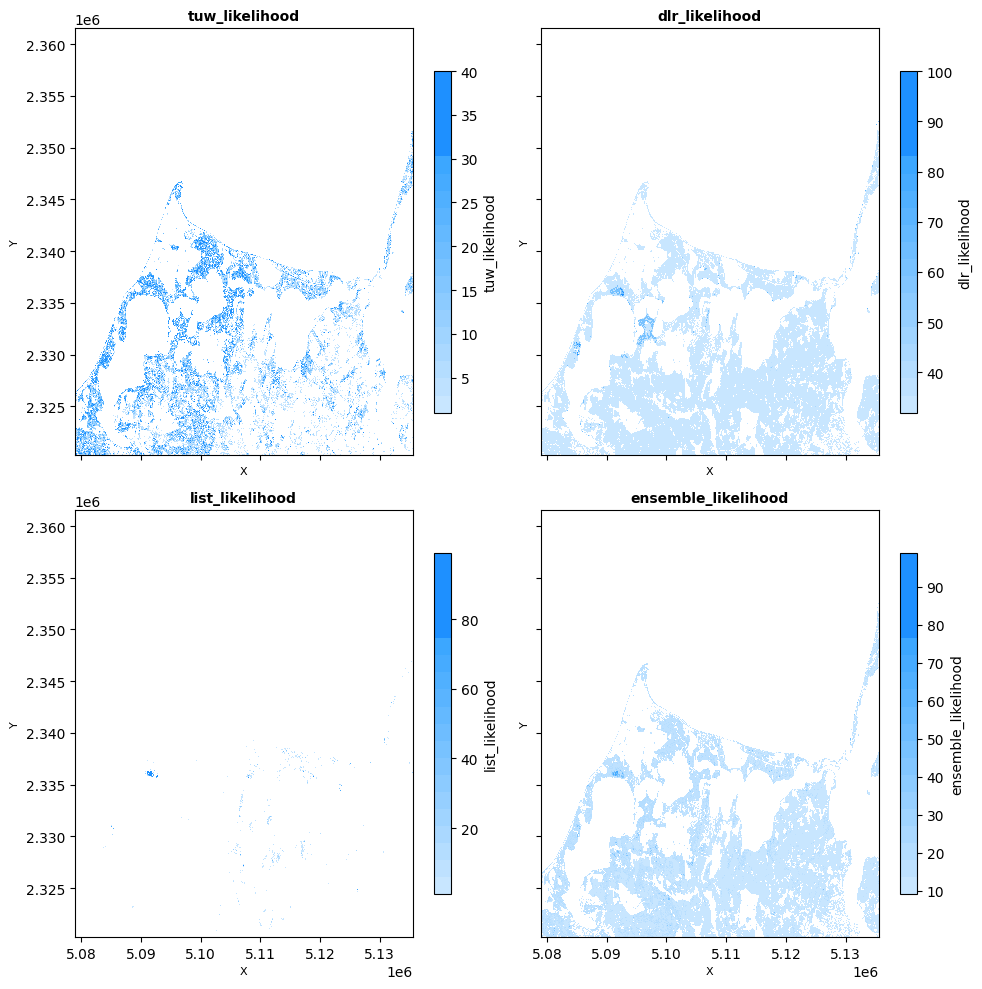

In [3]:
visualiser.select_and_refine_all_vars()
visualiser.plot_refined_data_grid(["tuw_likelihood","dlr_likelihood","list_likelihood","ensemble_likelihood"]) 

In [4]:
visualiser.prepare_for_map_overlay_all_vars()
fig = visualiser.plot_on_map(variable_name='tuw_likelihood',alpha=1 ,cmap=COLOR_PALETTES['light_to_strong_blue'], title="Basic Flood Likelihood with Map").opts(frame_width=frame_width, frame_height=frame_height)
inject_pin_overlay(fig, "outputs/baseline_with_map.html",top_px=top_px, right_px=right_px, title="Basic Flood Likelihood with Map")

Reprojecting data for map overlay...
Reprojecting data for map overlay...
Reprojecting data for map overlay...
Reprojecting data for map overlay...
Reprojecting data for map overlay...
Reprojecting data for map overlay...
Reprojecting data for map overlay...
Reprojecting data for map overlay...
Reprojecting data for map overlay...
Generating interactive map...
Pin injected into outputs\baseline_with_map.html @ top=380px, right=830px


Plotting 4 refined variables in a 2x2 grid...
Grid plot created successfully.


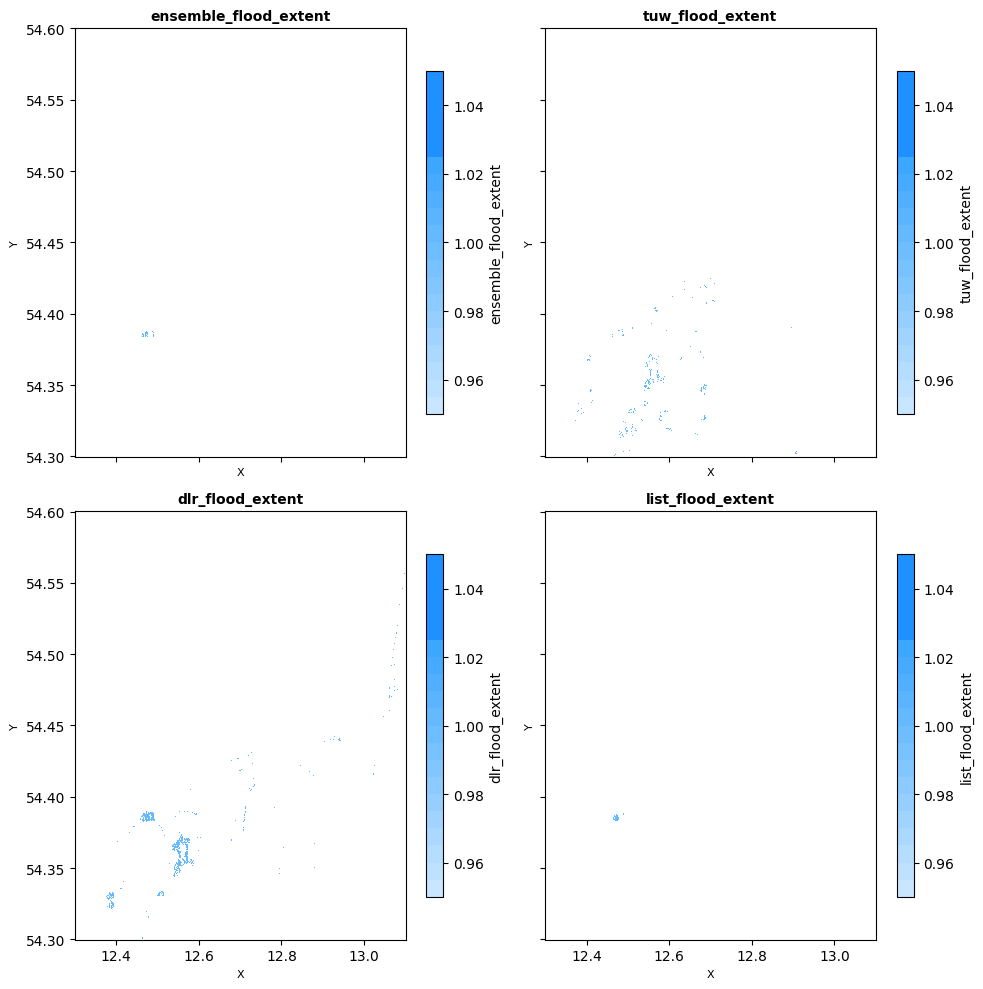

In [5]:
# visualiser.plot_plottable_data_grid()
visualiser.plot_plottable_data_grid(variables=['ensemble_flood_extent','tuw_flood_extent','dlr_flood_extent','list_flood_extent'],cmap=COLOR_PALETTES['light_to_strong_blue'])

In [6]:
fig = visualiser.plot_plottable_data("ensemble_likelihood",cmap=COLOR_PALETTES['light_to_strong_blue'])
hv.save(fig, 'figure_2.html', fmt='html')

Creating interactive map for 'ensemble_likelihood'...
Interactive map created successfully.


In [7]:
# matvis save
visualiser_file = "../../data/germany_visualiser.mapvis"
visualiser.save_to_file(visualiser_file)
del visualiser

Saving MapVisualiser to ../../data/germany_visualiser...


Saving MapVisualiser:   0%|          | 0/22 [00:00<?, ?step/s]

✓ MapVisualiser saved successfully to ../../data/germany_visualiser
  Main file: ../../data/germany_visualiser.mapvis
  Total files created: 6


In [8]:
visualiser2 = MapVisualiser(load_from_file=visualiser_file)
visualiser2.build_polygons('tuw_likelihood', smooth_distance=0.01, save_to_polygons=True)
visualiser2.build_polygons('ensemble_flood_extent',save_to_polygons=True)

Loading MapVisualiser from ../../data/germany_visualiser.mapvis...


Loading MapVisualiser:   0%|          | 0/4 [00:00<?, ?step/s]

✓ MapVisualiser loaded successfully
  CRS: PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
  Bounding box: [12.3 54.3 13.1 54.6]
  Flood variables: 9
  Refined variables: 9
  Plottable variables: 9
  Polygon variables: 0
  Saved on: 2025-12-07T13:46:22.087113
Building polygons for 'tuw_likelihood'...
  Filling holes in polygons...
  Smoothing polygons...
    Using projected CRS, buffer distance: 0.01 units
Polygons built successfully for 'tuw_likelihood'. Found 8868 polygon(s).
Building polygons for 'ensemble_flood_extent'...
  Filling holes in polygons...
  Smoothing pol

,geometry
0,"POLYGON ((12.919 54.44, 12.919 54.44, 12.919 5..."
1,"POLYGON ((12.489 54.388, 12.489 54.388, 12.489..."
2,"POLYGON ((12.463 54.387, 12.463 54.387, 12.463..."
3,"POLYGON ((12.463 54.386, 12.463 54.386, 12.463..."
4,"POLYGON ((12.464 54.385, 12.464 54.385, 12.464..."
5,"POLYGON ((12.463 54.386, 12.463 54.386, 12.463..."
6,"POLYGON ((12.491 54.385, 12.491 54.385, 12.491..."
7,"POLYGON ((12.464 54.384, 12.464 54.384, 12.464..."
8,"POLYGON ((12.487 54.387, 12.487 54.387, 12.487..."
9,"POLYGON ((12.465 54.384, 12.465 54.384, 12.465..."


In [9]:
fig = visualiser2.plot_polygon_on_map(variable_name='tuw_likelihood', alpha=0.7, color=COLOR_PALETTES['light_to_strong_blue'], title="Flood Likelihood with Polygons").opts(frame_width=frame_width, frame_height=frame_height)
inject_pin_overlay(
    fig,
    "outputs/polygon_basic.html",
    top_px=top_px,
    right_px=right_px - 40,
    title="Flood Likelihood with Polygons"
)

Pin injected into outputs\polygon_basic.html @ top=380px, right=790px


In [10]:
visualiser2.plot_polygon_on_map(variable_name='ensemble_flood_extent', alpha=0.7, color=COLOR_PALETTES['light_to_strong_blue'])
hv.save(fig, 'figure_4.html', fmt='html')

### Creating new variables - Product plottables 
using apply method you can apply simple mathematical functions on muliple plottable variables


Parsing expression: '(tuw_flood_extent_nz + 0.1) + ensemble_likelihood'
  Validating shapes (reference: (1048, 2793))...
  ✓ All variables have compatible shapes
  Evaluating expression...
  Saved to plottable_data['Flood1']
✓ Expression evaluated successfully
  Result shape: (1048, 2793)
  Result name: 'Flood1'
Parsing expression: '(ensemble_flood_extent_nz + 0.1) + ensemble_likelihood'
  Validating shapes (reference: (1048, 2793))...
  ✓ All variables have compatible shapes
  Evaluating expression...
  Saved to plottable_data['Flood2']
✓ Expression evaluated successfully
  Result shape: (1048, 2793)
  Result name: 'Flood2'
Parsing expression: '(dlr_flood_extent_nz + 0.1) + ensemble_likelihood'
  Validating shapes (reference: (1048, 2793))...
  ✓ All variables have compatible shapes
  Evaluating expression...
  Saved to plottable_data['Flood3']
✓ Expression evaluated successfully
  Result shape: (1048, 2793)
  Result name: 'Flood3'
Saving MapVisualiser to ../../data/germany2/germany_v

Saving MapVisualiser:   0%|          | 0/30 [00:00<?, ?step/s]

✓ MapVisualiser saved successfully to ../../data/germany2/germany_visualiser_with_floods
  Main file: ../../data/germany2/germany_visualiser_with_floods.mapvis
  Total files created: 8
Plotting 3 refined variables in a 1x3 grid...
Grid plot created successfully.


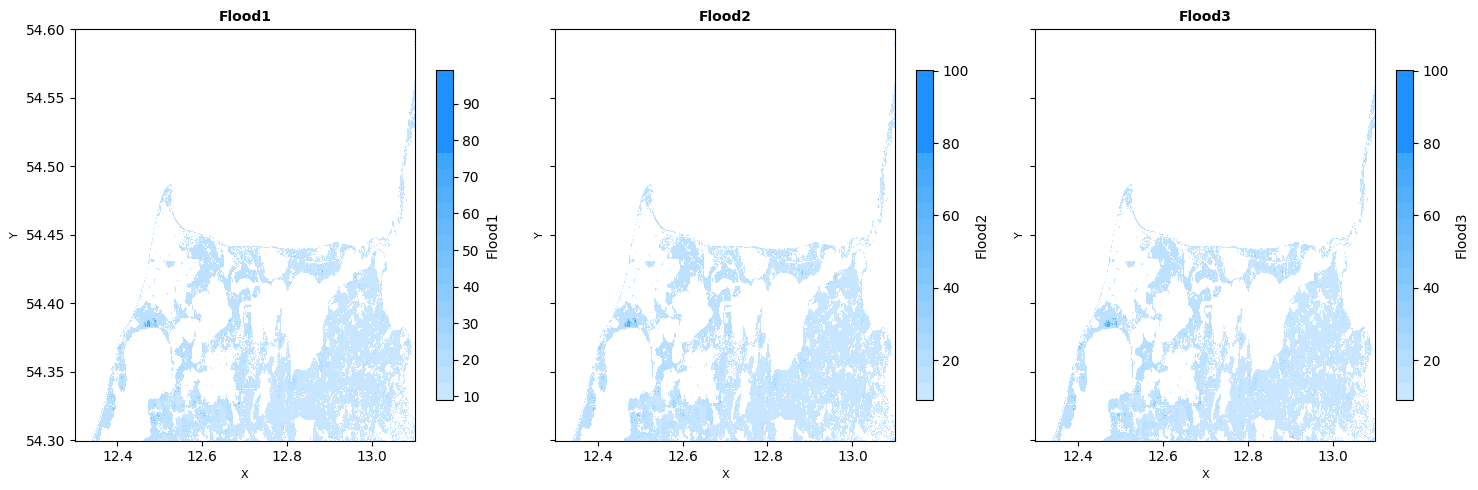

In [11]:
visualiser2.plottable_data['tuw_flood_extent_nz'] = visualiser2.plottable_data['tuw_flood_extent'].fillna(0)
visualiser2.plottable_data['ensemble_flood_extent_nz'] = visualiser2.plottable_data['ensemble_flood_extent'].fillna(0)
visualiser2.plottable_data['dlr_flood_extent_nz'] = visualiser2.plottable_data['dlr_flood_extent'].fillna(0)
    
visualiser2.apply_plottable("(tuw_flood_extent_nz + 0.1) + ensemble_likelihood", "Flood1", save_to_plottable=True)
visualiser2.apply_plottable("(ensemble_flood_extent_nz + 0.1) + ensemble_likelihood", "Flood2", save_to_plottable=True)
visualiser2.apply_plottable("(dlr_flood_extent_nz + 0.1) + ensemble_likelihood", "Flood3", save_to_plottable=True)

new_visualiser_file = "../../data/germany2/germany_visualiser_with_floods.mapvis"
visualiser2.save_to_file(new_visualiser_file)

visualiser2.plot_plottable_data_grid(variables=['Flood1','Flood2','Flood3'], cmap=COLOR_PALETTES['light_to_strong_blue'])

In [12]:
fig = visualiser2.plot_on_map(variable_name='Flood2', alpha=0.7, cmap=COLOR_PALETTES['light_to_strong_blue'])
hv.save(fig, 'figure_5.html', fmt='html')

Generating interactive map...


In [13]:
fig = visualiser2.plot_on_map(variable_name='Flood3', alpha=0.7, cmap=COLOR_PALETTES['blue_to_red_extended'].reverse(), title="Combined Flood Likelihood and Flood Extent").opts(frame_width=frame_width, frame_height=frame_height)
inject_pin_overlay(
    fig,
    "outputs/polygon_combined.html",
    top_px=top_px + 10,
    right_px=right_px - 25, 
    title="Combined Flood Likelihood and Flood Extent"
)
new_visualiser_file2 = "../../data/germany3/germany_visualiser_with_floods_map2.mapvis"
visualiser2.save_to_file(new_visualiser_file2)
del visualiser2

Generating interactive map...
Pin injected into outputs\polygon_combined.html @ top=390px, right=805px
Saving MapVisualiser to ../../data/germany3/germany_visualiser_with_floods_map2...


Saving MapVisualiser:   0%|          | 0/30 [00:00<?, ?step/s]

✓ MapVisualiser saved successfully to ../../data/germany3/germany_visualiser_with_floods_map2
  Main file: ../../data/germany3/germany_visualiser_with_floods_map2.mapvis
  Total files created: 8


### Apply binning for Flood variables
I define binnig in following as grouping range of given parameter (here likelihood or product parameter[likelihood x flood_extent]). For binning values $\forall_{b \in \{0, ...,n\}}v_b \in \mathbb{N}$, 
$$0 \leq v_0 \leq v_2 \leq ... \leq v_n \leq 100$$
bins are defined as follows $q_0 ,..., q_{n-1}$
$$
q_b = \{ b | v_b \leq x < v_{b+1}\}
$$

where x are values of given parameter at Ma


In [14]:
import pystac_client
from dask.distributed import Client
from dcloader import DcLoader
import matplotlib.pyplot as plt
import xarray as xr
from mapvisualiser import MapVisualiser
import rioxarray
import hvplot.xarray
from color_schemes import COLOR_PALETTES


new_visualiser_file2 = "../../data/germany3/germany_visualiser_with_floods_map2.mapvis"
visualiser3 = MapVisualiser(load_from_file=new_visualiser_file2)

Loading MapVisualiser from ../../data/germany3/germany_visualiser_with_floods_map2.mapvis...


Loading MapVisualiser:   0%|          | 0/6 [00:00<?, ?step/s]

✓ MapVisualiser loaded successfully
  CRS: PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
  Bounding box: [12.3 54.3 13.1 54.6]
  Flood variables: 9
  Refined variables: 9
  Plottable variables: 15
  Polygon variables: 2
  Saved on: 2025-12-07T13:48:17.404564


In [15]:
fig = visualiser3.plot_on_map(variable_name='Flood3', alpha=0.7, cmap=COLOR_PALETTES['blue_to_red_extended'].reverse())
hv.save(fig, 'figure_7.html', fmt='html')

Generating interactive map...


Building polygons for 'Flood3'...
  Filling holes in polygons...
  Smoothing polygons...
    Using projected CRS, buffer distance: 0.0001 units
Polygons built successfully for 'Flood3'. Found 16846 polygon(s).
Creating polygon map grid for 1 variables in a 1x1 layout...


Creating polygon grid: 0map [00:00, ?map/s]

Polygon grid plot created successfully.


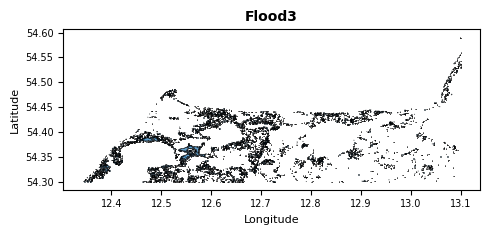

In [16]:
visualiser3.build_polygons("Flood3", threshold=20, save_to_polygons=True)
visualiser3.plot_polygons_grid(variables=['Flood3'], alpha=0.7, color=COLOR_PALETTES['blue_to_red_extended'].reverse())

In [17]:
#visualiser3.apply_binning(variable="Flood3", binning=[60, 80,90,92,95], save_to_plottable=True)
visualiser3.apply_binning(variable="Flood3", binning=[10,15,20,25,50], save_to_plottable=True)
fig = visualiser3.plot_plottable_data(variable_name='Flood3_binned', cmap=COLOR_PALETTES['blue_to_red_extended'].reverse(), title="Binned Flood Likelihood").opts(frame_width=frame_width, frame_height=frame_height)
inject_pin_overlay(
    fig,
    "outputs/polygon_binning.html",
    top_px=top_px,
    right_px=right_px - 40, title="Binned Flood Likelihood"
)

Creating interactive map for 'Flood3_binned'...
Interactive map created successfully.
Pin injected into outputs\polygon_binning.html @ top=380px, right=790px


### Creating polygons based on only top 2 bins

Building polygons for 'Flood3_binned'...
  Filling holes in polygons...
  Smoothing polygons...
    Using projected CRS, buffer distance: 0.0001 units
Polygons built successfully for 'Flood3_binned'. Found 128 polygon(s).
Creating polygon map grid for 2 variables in a 1x2 layout...


Creating polygon grid: 0map [00:00, ?map/s]

Polygon grid plot created successfully.


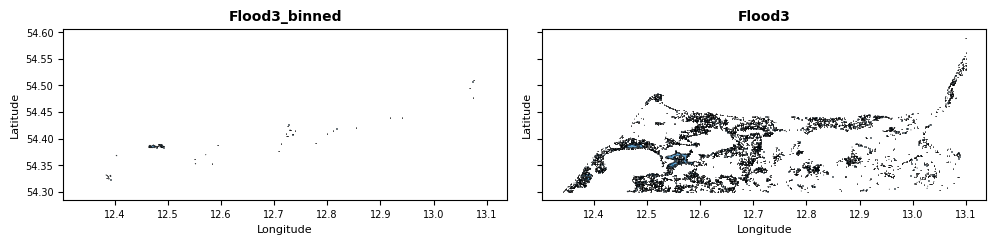

In [18]:
visualiser3.build_polygons("Flood3_binned", threshold=3, save_to_polygons=True)
visualiser3.plot_polygons_grid(variables=['Flood3_binned','Flood3','tuw_flood_extent'], alpha=0.7, color=COLOR_PALETTES['blue_to_red_extended'].reverse())